## **Average E\_run - Average Energy Consumption**

We define the average energy consumption of a KD method accross **5 student models**, **4 GPUs**, and **X number of telemetry samples**.

$$
E_{avg}^{(c)} = 
\frac{1}{R_c}
\sum_{r=1}^{R_c}
\left(
    \sum_{g=0}^{G-1}
    \sum_{i=1}^N
    \frac{energy\_mJ^{(r)}[g,i] - energy\_mJ^{(r)}[g, i-1]}{1000}
\right)
$$

**Where:**


In [2]:
import json
from pathlib import Path
from typing import List, Dict, Tuple, Union

import numpy as np
import pandas as pd


# ------------------------------------------------------------------
# Config: which metric to use for each task, and from where in JSON
# ------------------------------------------------------------------
# In the JSON:
# - Timestamp: "timestamp"
# - GPUs [0,1,2,3]
#   - index
#   - gpu_name
#   - power_watts
#   - energy_mJ
#   - memory_used_MB
#   - memory_total_MB
#   - gpu_utilization_percent
#   - memory_utilization_percent
#   - temperature_C
#   - fan_speed_percent -> NULL on every line


In [3]:
def load_energy_mj_series(jsonl_path: Path) -> np.ndarray:
    jsonl_path = Path(jsonl_path)
    records: List[Dict] = []

    with jsonl_path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rec = json.loads(line)
            records.append(rec)

    if not records:
        raise ValueError(f"No records loaded from {jsonl_path}")

    records.sort(key=lambda r: r["timestamp"])

    first_gpus = records[0]["gpus"]
    gpu_indices = sorted(g["gpu_index"] for g in first_gpus)
    num_gpus = len(gpu_indices)
    num_samples = len(records)

    index_map = {gpu_idx: i for i, gpu_idx in enumerate(gpu_indices)}

    energy_mj = np.zeros((num_gpus, num_samples), dtype=np.float64)

    for sample_idx, rec in enumerate(records):

        if "gpus" not in rec or not rec["gpus"]:
            continue

        for ginfo in rec["gpus"]:
            gpu_idx = ginfo["gpu_index"]
            arr_idx = index_map[gpu_idx]
            energy_mj[arr_idx, sample_idx] = ginfo["energy_mJ"]

    return energy_mj

$$
E_{run} = 
\sum_{g=0}^G
\sum_{i=1}^N
\frac{energy\_mJ[g,i] - energy\_mJ[g,i-1]}{1000}[J]
$$

In [10]:
def compute_E_run_MegaJoules(energy_mj: np.ndarray) -> float:
    delta_mj = energy_mj[:, 1:] - energy_mj[:, :-1]

    E_run_joules = delta_mj.sum()/1_000_000_000
    return float(E_run_joules)

def joules_to_kwh(E_joules: float) -> float:
    return E_joules/3_600_000.0

In [11]:
def compute_E_avg_for_config(run_paths: List[Path]) -> tuple[pd.DataFrame, pd.DataFrame]:
    run_paths = [Path(p) for p in run_paths]
    data = []

    for idx, path in enumerate(run_paths, start=1):
        energy_mj = load_energy_mj_series(path)
        E_run_MJ = compute_E_run_MegaJoules(energy_mj)
        E_run_kWh = joules_to_kwh(E_run_MJ)

        data.append({
            "run": idx,
            "file": str(path),
            "E_run_MJ": E_run_MJ,
            "E_run_kWh": E_run_kWh,
        })

    df = pd.DataFrame(data)

    E_avg_MJ = df["E_run_MJ"].mean()
    E_avg_kWh = df["E_run_kWh"].mean()

    summary = pd.DataFrame([{
        "E_avg_MJ": E_avg_MJ,
        "E_avg_kWh": E_avg_kWh,
        "num_runs": len(run_paths),
    }])

    return df, summary

def format_energy_summary_for_latex(df_summary: pd.DataFrame, label: str = "RespKD") -> str:
    row = df_summary.iloc[0]
    return (
        f"{label} & "
        f"{row['E_avg_MJ']:.2f} MJ & "
        f"{row['E_avg_kWh']:.4f} kWh & "
        f"{int(row['num_runs'])} \\\\"
    )



In [12]:
with open("../../logs/telemetry/2nd/response/22919/rpg-93-6.jsonl") as f:
    print(f.readline())

{"timestamp": "2025-11-14T02:02:16.609575-06:00", "gpus": [{"gpu_index": 0, "gpu_name": "NVIDIA H100 NVL", "power_watts": 63.814, "energy_mJ": 40361069025000.0, "memory_used_MB": 499.6875, "memory_total_MB": 95830.0, "gpu_utilization_percent": 0, "memory_utilization_percent": 0, "temperature_C": 40, "fan_speed_percent": null}, {"gpu_index": 1, "gpu_name": "NVIDIA H100 NVL", "power_watts": 62.111, "energy_mJ": 17337638351000.0, "memory_used_MB": 499.6875, "memory_total_MB": 95830.0, "gpu_utilization_percent": 0, "memory_utilization_percent": 0, "temperature_C": 39, "fan_speed_percent": null}, {"gpu_index": 2, "gpu_name": "NVIDIA H100 NVL", "power_watts": 66.099, "energy_mJ": 18251302790000.0, "memory_used_MB": 499.6875, "memory_total_MB": 95830.0, "gpu_utilization_percent": 0, "memory_utilization_percent": 0, "temperature_C": 39, "fan_speed_percent": null}, {"gpu_index": 3, "gpu_name": "NVIDIA H100 NVL", "power_watts": 65.581, "energy_mJ": 18176330481000.0, "memory_used_MB": 499.6875, "

In [13]:
resp_kd_runs = [
    Path("../../logs/telemetry/2nd/response/22919/rpg-93-6.jsonl"),
    Path("../../logs/telemetry/2nd/response/22942/rpg-93-6.jsonl"),
    Path("../../logs/telemetry/2nd/response/22943/rpg-93-6.jsonl"),
    Path("../../logs/telemetry/2nd/response/22944/rpg-93-6.jsonl"),
    Path("../../logs/telemetry/2nd/response/22945/rpg-93-6.jsonl"),
]

feat_kd_runs = [
    Path("../../logs/telemetry/2nd/feature/22920/rpg-93-4.jsonl"),
    Path("../../logs/telemetry/2nd/feature/22937/rpg-93-4.jsonl"),
    Path("../../logs/telemetry/2nd/feature/22938/rpg-93-4.jsonl"),
    Path("../../logs/telemetry/2nd/feature/22939/rpg-93-4.jsonl"),
    Path("../../logs/telemetry/2nd/feature/22941/rpg-93-4.jsonl"),
]

rel_kd_runs = [
    Path("../../logs/telemetry/2nd/relation/22921/rpg-93-5.jsonl"),
    Path("../../logs/telemetry/2nd/relation/22922/rpg-93-5.jsonl"),
    Path("../../logs/telemetry/2nd/relation/22926/rpg-93-5.jsonl"),
    Path("../../logs/telemetry/2nd/relation/22928/rpg-93-5.jsonl"),
    Path("../../logs/telemetry/2nd/relation/22929/rpg-93-5.jsonl"),
]

resp_df_runs, resp_summary = compute_E_avg_for_config(resp_kd_runs)
feat_df_runs, feat_summary = compute_E_avg_for_config(feat_kd_runs)
rel_df_runs, rel_summary = compute_E_avg_for_config(rel_kd_runs)


In [14]:
print(format_energy_summary_for_latex(resp_summary, label="Response KD"))
print(format_energy_summary_for_latex(feat_summary, label="Feature KD"))
print(format_energy_summary_for_latex(rel_summary, label="Relation KD"))


Response KD & 309.73 MJ & 0.0001 kWh & 5 \\
Feature KD & 530.95 MJ & 0.0001 kWh & 5 \\
Relation KD & 414.94 MJ & 0.0001 kWh & 5 \\


In [19]:
combined = pd.DataFrame([
    {
        "Method": "Response KD",
        "E_avg_MJ": resp_summary.iloc[0]["E_avg_MJ"],
        "E_avg_kWh": resp_summary.iloc[0]["E_avg_kWh"],
        "Runs": resp_summary.iloc[0]["num_runs"],
    },
    {
        "Method": "Feature KD",
        "E_avg_MJ": feat_summary.iloc[0]["E_avg_MJ"],
        "E_avg_kWh": feat_summary.iloc[0]["E_avg_kWh"],
        "Runs": feat_summary.iloc[0]["num_runs"],
    },
    {
        "Method": "Relation KD",
        "E_avg_MJ": rel_summary.iloc[0]["E_avg_MJ"],
        "E_avg_kWh": rel_summary.iloc[0]["E_avg_kWh"],
        "Runs": rel_summary.iloc[0]["num_runs"],
    },
])

combined


,Method,E_avg_MJ,E_avg_kWh,Runs
0,Response KD,309.726540,0.000086,5.0
1,Feature KD,530.949965,0.000147,5.0
2,Relation KD,414.937280,0.000115,5.0


<Figure size 600x400 with 0 Axes>

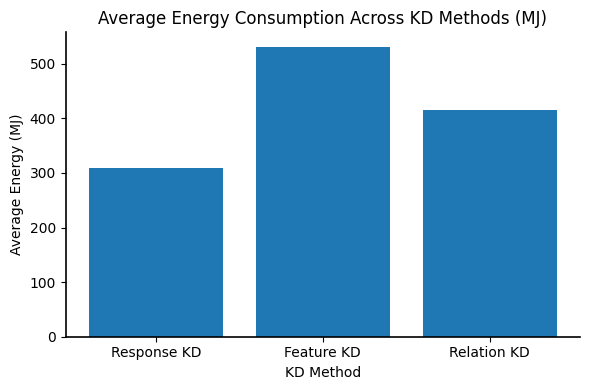

In [23]:
import matplotlib.pyplot as plt

# -----------------------------------------
# Bar plot: Average energy per KD method (J)
# -----------------------------------------
plt.figure(figsize=(6, 4))

x = combined["Method"]
y = combined["E_avg_MJ"]

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x, y)

ax.set_xlabel("KD Method")
ax.set_ylabel("Average Energy (MJ)")
ax.set_title("Average Energy Consumption Across KD Methods (MJ)")

# ---- Remove right & top border ----
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Optional: make left/bottom darker for publication
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)

plt.tight_layout()

# Save high-resolution figure
# plt.savefig("kd_energy_EavgJ.png", dpi=300, bbox_inches="tight")
# plt.savefig("kd_energy_EavgJ.pdf", bbox_inches="tight")

plt.show()


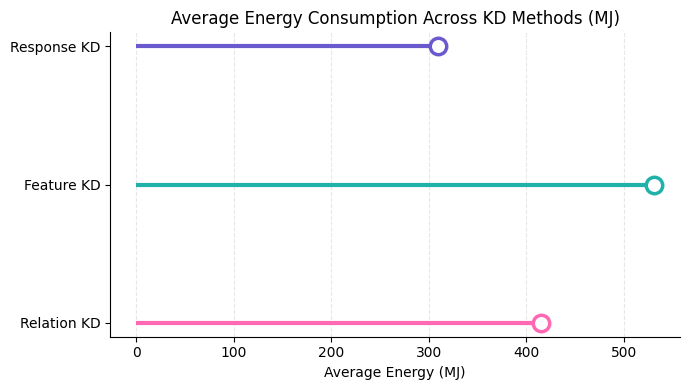

In [24]:
import matplotlib.pyplot as plt

# -----------------------------------------
# Lollipop chart with hollow markers
# -----------------------------------------

methods = combined["Method"].tolist()
joules = combined["E_avg_MJ"].tolist()
y_pos = range(len(methods))

# Unique colors for each method
unique_colors = {
    "Response KD": "#6A5ACD",   # SlateBlue
    "Feature KD":  "#20B2AA",   # LightSeaGreen
    "Relation KD": "#FF69B4",   # HotPink
}

fig, ax = plt.subplots(figsize=(7, 4))

for i, (method, value) in enumerate(zip(methods, joules)):
    color_val = unique_colors[method]

    # Stem line
    ax.hlines(y=i, xmin=0, xmax=value, color=color_val, linewidth=3)

    # Hollow marker: facecolor='white', edgecolor=color_val
    ax.scatter(
        value,
        i,
        s=140,
        facecolor="white",         # empty inside
        edgecolor=color_val,       # border same as category color
        linewidth=2.5,
        zorder=3
    )

# Axis formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(methods)
ax.set_xlabel("Average Energy (MJ)")
ax.set_title("Average Energy Consumption Across KD Methods (MJ)")

# Put first item at the top
ax.invert_yaxis()

# Grid only on X axis
ax.grid(axis="x", linestyle="--", alpha=0.3)

# Remove top & right borders (clean academic style)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

# Save publication quality versions
# plt.savefig("kd_energy_lollipop_J_hollow.png", dpi=600, bbox_inches="tight")
# plt.savefig("kd_energy_lollipop_J_hollow.pdf", bbox_inches="tight")

plt.show()
